In [ ]:
import numpy as np

# データ生成
np.random.seed(seed=1)
N = 200
K = 3
T = np.zeros((N,3), dtype = np.uint8)
X = np.zeros((N,2))
X_range0 = [-3,3]
X_range1 = [-3,3]

Mu = np.array([[-.5,-.5],[.5,1.0],[1,-.5]])
Sig = np.array([[.7,.7],[.8,.3],[.3,8]])

Pi = np.array([0.4,0.8,1])


for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n,k]  = 1
            break
            
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n,:] == 1,k]

In [ ]:
#２分類のデータをテスト・訓練データに分割
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, : ]

np.savez('class_data.npz', X_train=X_train, T_train=T_train,
         X_test=X_test, T_test=T_test,
         X_range0 = X_range0, X_range1 = X_range1)

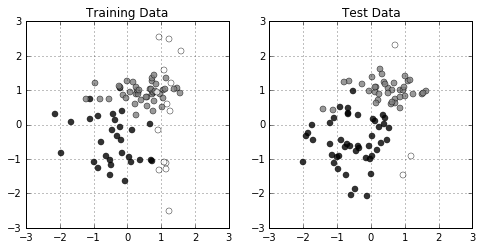

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

# データの図示
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle='none',
                 marker='o', markeredgecolor='black', color=c[i], alpha=0.8)

    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1,2,2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [ ]:
# シグモイド関数
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

# ネットワーク
def FNN(wv, M, K, x):
    N, D = x.shape
    w = wv[:M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1))
    z = np.zeros((N, M + 1))
    a = np.zeros((N, K))
    y = np.zeros((N, K))
    for n in range(N):
        # 中間層の計算
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])
            z[n, m] = Sigmoid(b[n, m])

        z[n, M] = 1
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])

        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz

    return y, a, z, b

WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])


(array([[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]]),
 array([[ 2.6971835 ,  2.6971835 ,  2.6971835 ],
        [ 1.49172649,  1.49172649,  1.49172649]]),
 array([[ 0.84859175,  0.84859175,  1.        ],
        [ 0.24586324,  0.24586324,  1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [ ]:
# 平均交差エントロピー誤差
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce

WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


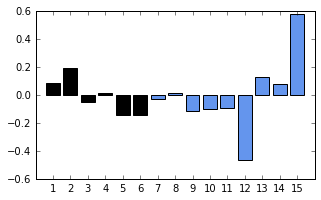

In [ ]:
# 数値微分
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)

    return dwv

def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)


M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()


In [ ]:
import time

# 数値微分を使った勾配法
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n ,alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n):
        wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M , K,x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

# Main
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print

KeyboardInterrupt: 